<a href="https://colab.research.google.com/github/KatherineElkins/networkx_miniproject_3_programming-humanity_2025/blob/main/IPHS200_social_network_analysis_barbie_REVISED_20251204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Analysis of the Barbie Screenplay

## Overview for Students

Welcome! This notebook analyzes the social relationships in the Barbie movie screenplay using **network science** - a field that studies how things (people, websites, neurons) connect to each other.

Think of it like analyzing a friend group:
- **Who hangs out together?** (Co-Presence Network)
- **Who talks to whom?** (Dialogue Network)
- **Who's the "connector" bringing different groups together?** (Betweenness)
- **Who has the most total interactions?** (Strength/Degree)

### What You'll Learn:
1. How to represent relationships as networks (graphs)
2. How to measure importance in different ways
3. How to visualize complex social structures
4. How to compare different types of relationships

### Structure:
- **Session 1**: Co-Presence Network (who shares scenes)
- **Session 2**: Dialogue Network (who speaks to whom)
- **Session 3**: Comprehensive Comparison & Report

---

**Note**: This notebook includes progress bars, logging, and automatic report generation to help you understand what's happening at each step!

## Setup: Installing Required Libraries

### What This Cell Does:
Before we can analyze networks, we need to install special Python libraries (think of them as toolboxes):

- **networkx**: Creates and analyzes network graphs
- **pandas**: Organizes data in tables (like Excel)
- **matplotlib**: Creates visualizations and charts
- **python-louvain**: Detects communities (groups of closely connected characters)
- **tqdm**: Shows progress bars so you know how long things take
- **reportlab**: Generates PDF reports

This cell also imports all the functions we'll need and sets up our workspace.

In [ ]:
# Install required libraries
!pip install -q networkx pandas matplotlib python-louvain tqdm reportlab pillow

# Import all necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import community.community_louvain as community_louvain
import io
import json
import datetime
from tqdm.notebook import tqdm
from pathlib import Path
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
from reportlab.lib.enums import TA_CENTER, TA_LEFT

# Set up output directories
output_dir = Path('network_analysis_outputs')
output_dir.mkdir(exist_ok=True)
(output_dir / 'visualizations').mkdir(exist_ok=True)
(output_dir / 'logs').mkdir(exist_ok=True)
(output_dir / 'data').mkdir(exist_ok=True)

# Configure matplotlib for better-looking plots
plt.style.use('default')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['savefig.bbox'] = 'tight'

print("✓ All libraries installed and imported successfully!")
print(f"✓ Output directory created: {output_dir.absolute()}")
print(f"\nCurrent timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.3 MB/s eta 0:00:00
✓ All libraries installed and imported successfully!
✓ Output directory created: /content/network_analysis_outputs

Current timestamp: 2025-12-04 17:38:23


## Utility Functions: Helper Code

### What This Cell Does:
This cell defines reusable functions that help us throughout the notebook. Think of these as "recipes" we can use multiple times:

1. **Logging**: Writes timestamped messages to a file so we have a record
2. **Progress tracking**: Shows how far along we are in calculations
3. **Data validation**: Checks if the uploaded data is formatted correctly
4. **Visualization saving**: Automatically saves charts as image files

You don't need to understand every line - just know these functions make everything else work smoothly!

In [ ]:
# Global log file path
log_file_path = output_dir / 'logs' / f'analysis_log_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'

def log_message(message, level="INFO"):
    """
    Write a timestamped message to the log file and print to console.

    Args:
        message: The message to log
        level: Log level (INFO, WARNING, ERROR, SUCCESS)
    """
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_entry = f"[{timestamp}] [{level}] {message}"

    # Print to console with color coding
    colors_map = {
        'INFO': '\033[94m',     # Blue
        'SUCCESS': '\033[92m',  # Green
        'WARNING': '\033[93m',  # Yellow
        'ERROR': '\033[91m'     # Red
    }
    reset_color = '\033[0m'
    print(f"{colors_map.get(level, '')}[{level}]{reset_color} {message}")

    # Write to file
    with open(log_file_path, 'a', encoding='utf-8') as f:
        f.write(log_entry + '\n')

def validate_network_data(df, required_columns=['Source', 'Target', 'Weight'], data_type='network'):
    """
    Validate that the uploaded data has the correct format.

    Args:
        df: DataFrame to validate
        required_columns: List of required column names
        data_type: Type of data for error messages

    Returns:
        tuple: (is_valid, error_message)
    """
    # Check if DataFrame is empty
    if df.empty:
        return False, f"{data_type} data is empty"

    # Check required columns
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        return False, f"Missing required columns: {', '.join(missing_cols)}"

    # Check for null values in required columns
    for col in required_columns:
        if df[col].isnull().any():
            return False, f"Column '{col}' contains null values"

    # Check that Weight column contains positive numbers
    if 'Weight' in required_columns:
        if not pd.api.types.is_numeric_dtype(df['Weight']):
            return False, "Weight column must contain numeric values"
        if (df['Weight'] <= 0).any():
            return False, "Weight column must contain positive values"

    return True, "Data validation passed"

def save_visualization(fig, filename, description=""):
    """
    Save a matplotlib figure to the visualizations directory.

    Args:
        fig: Matplotlib figure object
        filename: Name for the saved file (without extension)
        description: Description for logging

    Returns:
        Path to saved file
    """
    filepath = output_dir / 'visualizations' / f'{filename}.png'
    fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    log_message(f"Saved visualization: {filename}.png" + (f" ({description})" if description else ""), "SUCCESS")
    return filepath

def create_progress_bar(total, desc="Processing"):
    """
    Create a progress bar for tracking operations.

    Args:
        total: Total number of steps
        desc: Description of what's being processed

    Returns:
        tqdm progress bar object
    """
    return tqdm(total=total, desc=desc, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

def safe_network_metric(func, graph, metric_name, **kwargs):
    """
    Safely calculate a network metric with error handling.

    Args:
        func: NetworkX function to call
        graph: Network graph
        metric_name: Name of metric for logging
        **kwargs: Additional arguments for the function

    Returns:
        Result of function or None if error
    """
    try:
        result = func(graph, **kwargs)
        log_message(f"Calculated {metric_name} successfully", "SUCCESS")
        return result
    except Exception as e:
        log_message(f"Error calculating {metric_name}: {str(e)}", "ERROR")
        return None

# Initialize the log file
log_message("="*70, "INFO")
log_message("Network Analysis Session Started", "INFO")
log_message("="*70, "INFO")
print("\n✓ Utility functions loaded successfully!")

[INFO] ======================================================================
[INFO] Network Analysis Session Started
[INFO] ======================================================================

✓ Utility functions loaded successfully!


## Data Loading: Getting the Network Data

### What This Cell Does:
This cell loads the data about character relationships. You have two options:

**Option 1: Use the Built-in Demo Data** (default)
- Just run the cell as-is
- Uses pre-loaded Barbie movie data

**Option 2: Upload Your Own Data**
- Set `USE_UPLOADED_DATA = True`
- Upload two CSV files with this exact format:

**Co-Presence CSV Format** (who shares scenes):
```
Source,Target,Weight
Character A,Character B,5
Character A,Character C,3
```
- **Source**: First character's name
- **Target**: Second character's name  
- **Weight**: Number of scenes they share (positive whole number)

**Dialogue CSV Format** (who speaks to whom):
```
Source,Target,Weight
Character A,Character B,10
Character B,Character A,8
```
- **Source**: Character who is speaking
- **Target**: Character being spoken to
- **Weight**: Number of dialogue lines (positive whole number)

### Key Differences:
- Co-Presence is **undirected** (A↔B is same as B↔A)
- Dialogue is **directed** (A→B is different from B→A)

In [ ]:
# =============================================================================
# CONFIGURATION: Change this to True to use uploaded CSV files
# =============================================================================
USE_UPLOADED_DATA = False  # Set to True to upload your own data

# =============================================================================
# Demo Data: Barbie Movie Character Networks
# =============================================================================
demo_copresence_data = """Source,Target,Weight
Barbie Margot,Ken Ryan Gosling,20
Barbie Margot,Gloria,12
Barbie Margot,Sasha,11
Barbie Margot,Weird Barbie,9
Barbie Margot,Ken Simu Liu,8
Barbie Margot,Mattel CEO,6
Barbie Margot,President Barbie,5
Barbie Margot,Allan,4
Barbie Margot,Ruth,3
Ken Ryan Gosling,Ken Simu Liu,10
Ken Ryan Gosling,President Barbie,7
Ken Ryan Gosling,Doctor Barbie,6
Ken Ryan Gosling,Physicist Barbie,6
Ken Ryan Gosling,Ken Kingsley,5
Ken Ryan Gosling,Gloria,4
Ken Ryan Gosling,Sasha,4
Ken Ryan Gosling,Mattel CEO,4
Ken Ryan Gosling,Weird Barbie,2
Gloria,Sasha,8
Gloria,Mattel CEO,5
Gloria,Weird Barbie,3
Gloria,Nerdy Well Meaning Dad,3
Sasha,Nerdy Well Meaning Dad,3
Mattel CEO,Aaron (Mattel Employee),4
Mattel CEO,Other Board Members,3
President Barbie,Doctor Barbie,5
President Barbie,Physicist Barbie,5
President Barbie,Judge Barbie,5
Doctor Barbie,Physicist Barbie,4
Doctor Barbie,Judge Barbie,4
Physicist Barbie,Judge Barbie,4
Ken Simu Liu,Ken Kingsley,4
Ken Simu Liu,Ken Ncuti,4
Ken Simu Liu,Ken Scott,4
Allan,Skipper,3
Allan,Midge,2
Allan,Weird Barbie,4
Skipper,Midge,2
Midge,Allan,1
Judge Barbie,Journalist Barbie,2
"""

demo_dialogue_data = """Source,Target,Weight
Barbie Margot,Ken Ryan Gosling,35
Barbie Margot,Gloria,25
Barbie Margot,Sasha,15
Barbie Margot,Weird Barbie,12
Barbie Margot,Mattel CEO,8
Barbie Margot,Ruth,6
Barbie Margot,President Barbie,5
Barbie Margot,Allan,4
Ken Ryan Gosling,Barbie Margot,40
Ken Ryan Gosling,Ken Simu Liu,12
Ken Ryan Gosling,Mattel CEO,3
Ken Ryan Gosling,Ken Ncuti,3
Ken Ryan Gosling,Ken Kingsley,3
Gloria,Barbie Margot,30
Gloria,Sasha,10
Gloria,Nerdy Well Meaning Dad,5
Gloria,Mattel CEO,4
Sasha,Barbie Margot,10
Sasha,Gloria,5
Sasha,Nerdy Well Meaning Dad,3
Weird Barbie,Barbie Margot,15
Weird Barbie,Allan,5
Mattel CEO,Barbie Margot,10
Mattel CEO,Gloria,5
Mattel CEO,Aaron (Mattel Employee),4
President Barbie,Ken Ryan Gosling,5
President Barbie,Doctor Barbie,3
President Barbie,Judge Barbie,3
Ruth,Barbie Margot,10
Allan,Weird Barbie,4
Allan,Gloria,3
Ken Simu Liu,Ken Ryan Gosling,10
Ken Simu Liu,Ken Ncuti,4
Doctor Barbie,President Barbie,3
Physicist Barbie,President Barbie,2
Judge Barbie,President Barbie,2
Skipper,Allan,1
Midge,Skipper,1
"""

# =============================================================================
# Load Data Based on Configuration
# =============================================================================
log_message("Starting data loading process...", "INFO")

if USE_UPLOADED_DATA:
    log_message("Attempting to load uploaded CSV files...", "INFO")
    print("\n📁 Please upload your CSV files when prompted...\n")

    try:
        from google.colab import files

        # Upload Co-Presence data
        print("Upload Co-Presence Network CSV (Source,Target,Weight):")
        uploaded_copresence = files.upload()
        copresence_filename = list(uploaded_copresence.keys())[0]
        df_copresence = pd.read_csv(io.BytesIO(uploaded_copresence[copresence_filename]))

        # Upload Dialogue data
        print("\nUpload Dialogue Network CSV (Source,Target,Weight):")
        uploaded_dialogue = files.upload()
        dialogue_filename = list(uploaded_dialogue.keys())[0]
        df_dialogue = pd.read_csv(io.BytesIO(uploaded_dialogue[dialogue_filename]))

        log_message(f"Uploaded files: {copresence_filename}, {dialogue_filename}", "SUCCESS")

    except ImportError:
        log_message("Not running in Google Colab - attempting local file upload", "WARNING")
        print("❗ Please ensure your CSV files are in the current directory")
        copresence_file = input("Enter co-presence CSV filename: ")
        dialogue_file = input("Enter dialogue CSV filename: ")
        df_copresence = pd.read_csv(copresence_file)
        df_dialogue = pd.read_csv(dialogue_file)

else:
    # Use demo data
    log_message("Using built-in demo data (Barbie screenplay)", "INFO")
    df_copresence = pd.read_csv(io.StringIO(demo_copresence_data))
    df_dialogue = pd.read_csv(io.StringIO(demo_dialogue_data))

# =============================================================================
# Validate Data
# =============================================================================
print("\n🔍 Validating data format...\n")
pbar = create_progress_bar(2, "Validating datasets")

# Validate co-presence data
is_valid, message = validate_network_data(df_copresence, data_type='Co-Presence')
if not is_valid:
    log_message(f"Co-Presence data validation failed: {message}", "ERROR")
    raise ValueError(f"Co-Presence data validation failed: {message}")
log_message("Co-Presence data validated successfully", "SUCCESS")
pbar.update(1)

# Validate dialogue data
is_valid, message = validate_network_data(df_dialogue, data_type='Dialogue')
if not is_valid:
    log_message(f"Dialogue data validation failed: {message}", "ERROR")
    raise ValueError(f"Dialogue data validation failed: {message}")
log_message("Dialogue data validated successfully", "SUCCESS")
pbar.update(1)
pbar.close()

# =============================================================================
# Display Data Summary
# =============================================================================
print("\n" + "="*70)
print("📊 DATA LOADING SUMMARY")
print("="*70)
print(f"\n✓ Co-Presence Network:")
print(f"  - Total edges (relationships): {len(df_copresence)}")
print(f"  - Unique characters: {len(set(df_copresence['Source']) | set(df_copresence['Target']))}")
print(f"  - Total scene-sharing instances: {df_copresence['Weight'].sum()}")
print(f"\n✓ Dialogue Network:")
print(f"  - Total edges (conversations): {len(df_dialogue)}")
print(f"  - Unique characters: {len(set(df_dialogue['Source']) | set(df_dialogue['Target']))}")
print(f"  - Total dialogue exchanges: {df_dialogue['Weight'].sum()}")
print("\n" + "="*70)

print("\n📋 First 5 Co-Presence Relationships:")
print(df_copresence.head())
print("\n📋 First 5 Dialogue Exchanges:")
print(df_dialogue.head())

# Save data to files
df_copresence.to_csv(output_dir / 'data' / 'copresence_data.csv', index=False)
df_dialogue.to_csv(output_dir / 'data' / 'dialogue_data.csv', index=False)
log_message("Data saved to CSV files", "SUCCESS")

[INFO] Starting data loading process...
[INFO] Using built-in demo data (Barbie screenplay)

🔍 Validating data format...



Validating datasets:   0%|          | 0/2 [00:00<?]

[SUCCESS] Co-Presence data validated successfully
[SUCCESS] Dialogue data validated successfully

📊 DATA LOADING SUMMARY

✓ Co-Presence Network:
  - Total edges (relationships): 40
  - Unique characters: 22
  - Total scene-sharing instances: 208

✓ Dialogue Network:
  - Total edges (conversations): 38
  - Unique characters: 19
  - Total dialogue exchanges: 328


📋 First 5 Co-Presence Relationships:
          Source            Target  Weight
0  Barbie Margot  Ken Ryan Gosling      20
1  Barbie Margot            Gloria      12
2  Barbie Margot             Sasha      11
3  Barbie Margot      Weird Barbie       9
4  Barbie Margot      Ken Simu Liu       8

📋 First 5 Dialogue Exchanges:
          Source            Target  Weight
0  Barbie Margot  Ken Ryan Gosling      35
1  Barbie Margot            Gloria      25
2  Barbie Margot             Sasha      15
3  Barbie Margot      Weird Barbie      12
4  Barbie Margot        Mattel CEO       8
[SUCCESS] Data saved to CSV files


# SESSION 1: Co-Presence Network Analysis

## Building the Co-Presence Network

### What This Cell Does:
Now we create our first network! Think of this like mapping out a social web:

**Network Type**: Undirected Graph (connections go both ways)
- If Character A shares a scene with Character B, then B also shares with A
- It's like being "Facebook friends" - the relationship is mutual

**What We're Measuring**:
- **Nodes** = Characters (the dots in our network)
- **Edges** = Shared scenes (the lines connecting the dots)
- **Weight** = How many scenes they share (thicker lines = more screentime together)

**Why This Matters**:
This network shows us physical proximity and presence - who the script keeps putting together in scenes. It reveals the screenplay's structural decisions about which characters inhabit the same spaces.

In [ ]:
print("\n" + "="*70)
print("🎬 SESSION 1: CO-PRESENCE NETWORK ANALYSIS")
print("="*70)
log_message("Starting Session 1: Co-Presence Network Analysis", "INFO")

# Create the undirected graph
log_message("Creating co-presence network graph...", "INFO")
G = nx.from_pandas_edgelist(
    df_copresence,
    source='Source',
    target='Target',
    edge_attr='Weight'
)

# Verify graph creation
if G.number_of_nodes() == 0:
    log_message("ERROR: Graph has no nodes!", "ERROR")
    raise ValueError("Failed to create graph - no nodes found")

print(f"\n✓ Graph created successfully!")
print(f"  - Nodes (characters): {G.number_of_nodes()}")
print(f"  - Edges (relationships): {G.number_of_edges()}")
print(f"  - Graph type: {'Connected' if nx.is_connected(G) else 'Disconnected'}")
print(f"  - Graph density: {nx.density(G):.3f}")
print(f"    (Density measures how many connections exist vs. how many are possible)")

log_message(f"Co-presence graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges", "SUCCESS")


🎬 SESSION 1: CO-PRESENCE NETWORK ANALYSIS
[INFO] Starting Session 1: Co-Presence Network Analysis
[INFO] Creating co-presence network graph...

✓ Graph created successfully!
  - Nodes (characters): 22
  - Edges (relationships): 39
  - Graph type: Connected
  - Graph density: 0.169
    (Density measures how many connections exist vs. how many are possible)
[SUCCESS] Co-presence graph: 22 nodes, 39 edges


## Calculating Centrality Metrics

### What This Cell Does:
This calculates different ways to measure how "important" each character is:

**1. Strength (Weighted Degree)**
- How much total screentime a character shares with others
- Like counting total minutes at a party with different people
- **High strength** = Protagonist, always on screen

**2. Betweenness Centrality**
- How often a character lies on the shortest path between other characters
- Like being the "bridge" person who connects different friend groups
- **High betweenness** = Connector, plot catalyst

**3. Closeness Centrality**
- How quickly a character can reach all other characters
- Like living in the center of town vs. on the outskirts
- **High closeness** = Central, well-integrated

**Global Network Metrics**:
- **Transitivity** = Are your friends also friends with each other? (clustering)
- **Average Path Length** = How many "hops" to connect any two characters?
- **Maximum Clique** = Largest group where everyone shares scenes with everyone

In [ ]:
print("\n🔢 Calculating centrality metrics...\n")
log_message("Calculating co-presence centrality metrics", "INFO")

# Initialize results dictionary
centrality_results = {}

# Progress bar for centrality calculations
pbar = create_progress_bar(6, "Computing metrics")

# 1. Weighted Degree (Strength)
weighted_degree = safe_network_metric(dict, G.degree(weight='Weight'), "Weighted Degree")
if weighted_degree:
    centrality_results['strength'] = weighted_degree
pbar.update(1)

# 2. Betweenness Centrality
betweenness = safe_network_metric(nx.betweenness_centrality, G, "Betweenness Centrality")
if betweenness:
    centrality_results['betweenness'] = betweenness
pbar.update(1)

# 3. Closeness Centrality
closeness = safe_network_metric(nx.closeness_centrality, G, "Closeness Centrality")
if closeness:
    centrality_results['closeness'] = closeness
pbar.update(1)

# 4. Transitivity (Global Clustering)
transitivity = nx.transitivity(G)
log_message(f"Transitivity (global clustering): {transitivity:.3f}", "SUCCESS")
pbar.update(1)

# 5. Average Shortest Path Length
try:
    avg_shortest_path = nx.average_shortest_path_length(G)
    log_message(f"Average shortest path length: {avg_shortest_path:.3f}", "SUCCESS")
except nx.NetworkXError:
    avg_shortest_path = "N/A (Graph is disconnected)"
    log_message("Graph is disconnected - cannot calculate average path length", "WARNING")
pbar.update(1)

# 6. Maximum Clique
all_cliques = list(nx.find_cliques(G))
largest_clique = sorted(all_cliques, key=len, reverse=True)[0]
max_clique_size = len(largest_clique)
log_message(f"Maximum clique size: {max_clique_size} nodes", "SUCCESS")
pbar.update(1)
pbar.close()

# Create comprehensive DataFrame
co_presence_df = pd.DataFrame({
    'Character': list(G.nodes()),
    'Co-Presence Strength': [centrality_results['strength'].get(node, 0) for node in G.nodes()],
    'Co-Presence Betweenness': [centrality_results['betweenness'].get(node, 0) for node in G.nodes()],
    'Co-Presence Closeness': [centrality_results['closeness'].get(node, 0) for node in G.nodes()]
}).sort_values(by='Co-Presence Strength', ascending=False)

# Display results
print("\n" + "="*70)
print("📊 CO-PRESENCE CENTRALITY METRICS")
print("="*70)
print(co_presence_df.to_string(index=False))

print("\n" + "="*70)
print("🌐 GLOBAL NETWORK METRICS")
print("="*70)
print(f"1. Transitivity (Global Clustering): {transitivity:.3f}")
print(f"   → Probability that two characters who share scenes with a third also share scenes")
print(f"\n2. Average Shortest Path Length: {avg_shortest_path}")
print(f"   → Average number of 'hops' between any two characters")
print(f"\n3. Maximum Clique Size: {max_clique_size} characters")
print(f"   → Largest group where everyone shares scenes with everyone else")
print(f"   → Members: {', '.join(largest_clique)}")

# Save to CSV
co_presence_df.to_csv(output_dir / 'data' / 'copresence_centrality.csv', index=False)
log_message("Co-presence centrality data saved", "SUCCESS")


🔢 Calculating centrality metrics...

[INFO] Calculating co-presence centrality metrics


Computing metrics:   0%|          | 0/6 [00:00<?]

[SUCCESS] Calculated Weighted Degree successfully
[SUCCESS] Calculated Betweenness Centrality successfully
[SUCCESS] Calculated Closeness Centrality successfully
[SUCCESS] Transitivity (global clustering): 0.416
[SUCCESS] Average shortest path length: 2.567
[SUCCESS] Maximum clique size: 4 nodes

📊 CO-PRESENCE CENTRALITY METRICS
              Character  Co-Presence Strength  Co-Presence Betweenness  Co-Presence Closeness
          Barbie Margot                    78                 0.399206               0.617647
       Ken Ryan Gosling                    68                 0.351587               0.600000
                 Gloria                    35                 0.068254               0.488372
           Ken Simu Liu                    30                 0.195238               0.466667
       President Barbie                    27                 0.120635               0.477273
                  Sasha                    26                 0.033333               0.446809
           

## Community Detection

### What This Cell Does:
This uses an algorithm (Louvain method) to automatically find "communities" - groups of characters who share many scenes with each other but fewer with outsiders.

**Think of it like**:
- Finding cliques in a high school
- Identifying departments in a company
- Discovering neighborhoods in a city

**Why This Matters**:
Communities reveal the screenplay's structure:
- Are there separate storylines that don't interact much?
- Which characters belong to which "world" (Barbieland vs. Real World)?
- Who bridges between communities (plot catalysts)?

**The Algorithm**:
The Louvain method tries different groupings and picks the one that maximizes "modularity" - a measure of how separated the groups are. Higher modularity = more distinct communities.

In [ ]:
print("\n🔍 Detecting communities...\n")
log_message("Detecting communities using Louvain algorithm", "INFO")

# Detect communities
partition = community_louvain.best_partition(G, weight='Weight')
community_count = max(partition.values()) + 1
modularity = community_louvain.modularity(partition, G, weight='Weight')

log_message(f"Detected {community_count} communities with modularity {modularity:.3f}", "SUCCESS")

# Organize communities
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Display communities
print("="*70)
print("👥 DETECTED COMMUNITIES")
print("="*70)
print(f"\nModularity Score: {modularity:.3f}")
print(f"(Measures how well-separated the communities are. Range: -0.5 to 1.0)\n")

for comm_id in sorted(communities.keys()):
    members = communities[comm_id]
    print(f"\nCommunity {comm_id + 1} ({len(members)} members):")
    print(f"  {', '.join(members)}")

# Add community info to dataframe
co_presence_df['Community'] = co_presence_df['Character'].map(partition)

# Save community data
community_data = {
    'modularity': modularity,
    'num_communities': community_count,
    'communities': {f"Community_{i+1}": members for i, members in communities.items()}
}
with open(output_dir / 'data' / 'copresence_communities.json', 'w') as f:
    json.dump(community_data, f, indent=2)
log_message("Community detection results saved", "SUCCESS")


🔍 Detecting communities...

[INFO] Detecting communities using Louvain algorithm
[SUCCESS] Detected 5 communities with modularity 0.300
👥 DETECTED COMMUNITIES

Modularity Score: 0.300
(Measures how well-separated the communities are. Range: -0.5 to 1.0)


Community 1 (3 members):
  Mattel CEO, Aaron (Mattel Employee), Other Board Members

Community 2 (5 members):
  Ken Ryan Gosling, Ken Simu Liu, Ken Kingsley, Ken Ncuti, Ken Scott

Community 3 (5 members):
  President Barbie, Doctor Barbie, Physicist Barbie, Judge Barbie, Journalist Barbie

Community 4 (6 members):
  Barbie Margot, Gloria, Sasha, Weird Barbie, Ruth, Nerdy Well Meaning Dad

Community 5 (3 members):
  Allan, Skipper, Midge
[SUCCESS] Community detection results saved


## Visualization 1: Community Structure

### What This Cell Does:
Creates a visual map of the network where:
- **Different colors** = Different communities
- **Node size** = Same for everyone (to focus on structure, not individual importance)
- **Line thickness** = Weight of connection (more scenes shared = thicker line)
- **Layout algorithm** = Positions nodes so connected ones are closer together

**How to Read This Visualization**:
1. Look for distinct color clusters (separate communities)
2. Notice which characters bridge between colors (connectors)
3. See which groups are tightly connected (thick lines) vs. loosely (thin lines)
4. Identify isolated characters or groups on the periphery


🎨 Creating community structure visualization...

[INFO] Generating community visualization
[SUCCESS] Saved visualization: copresence_communities.png (Community structure)


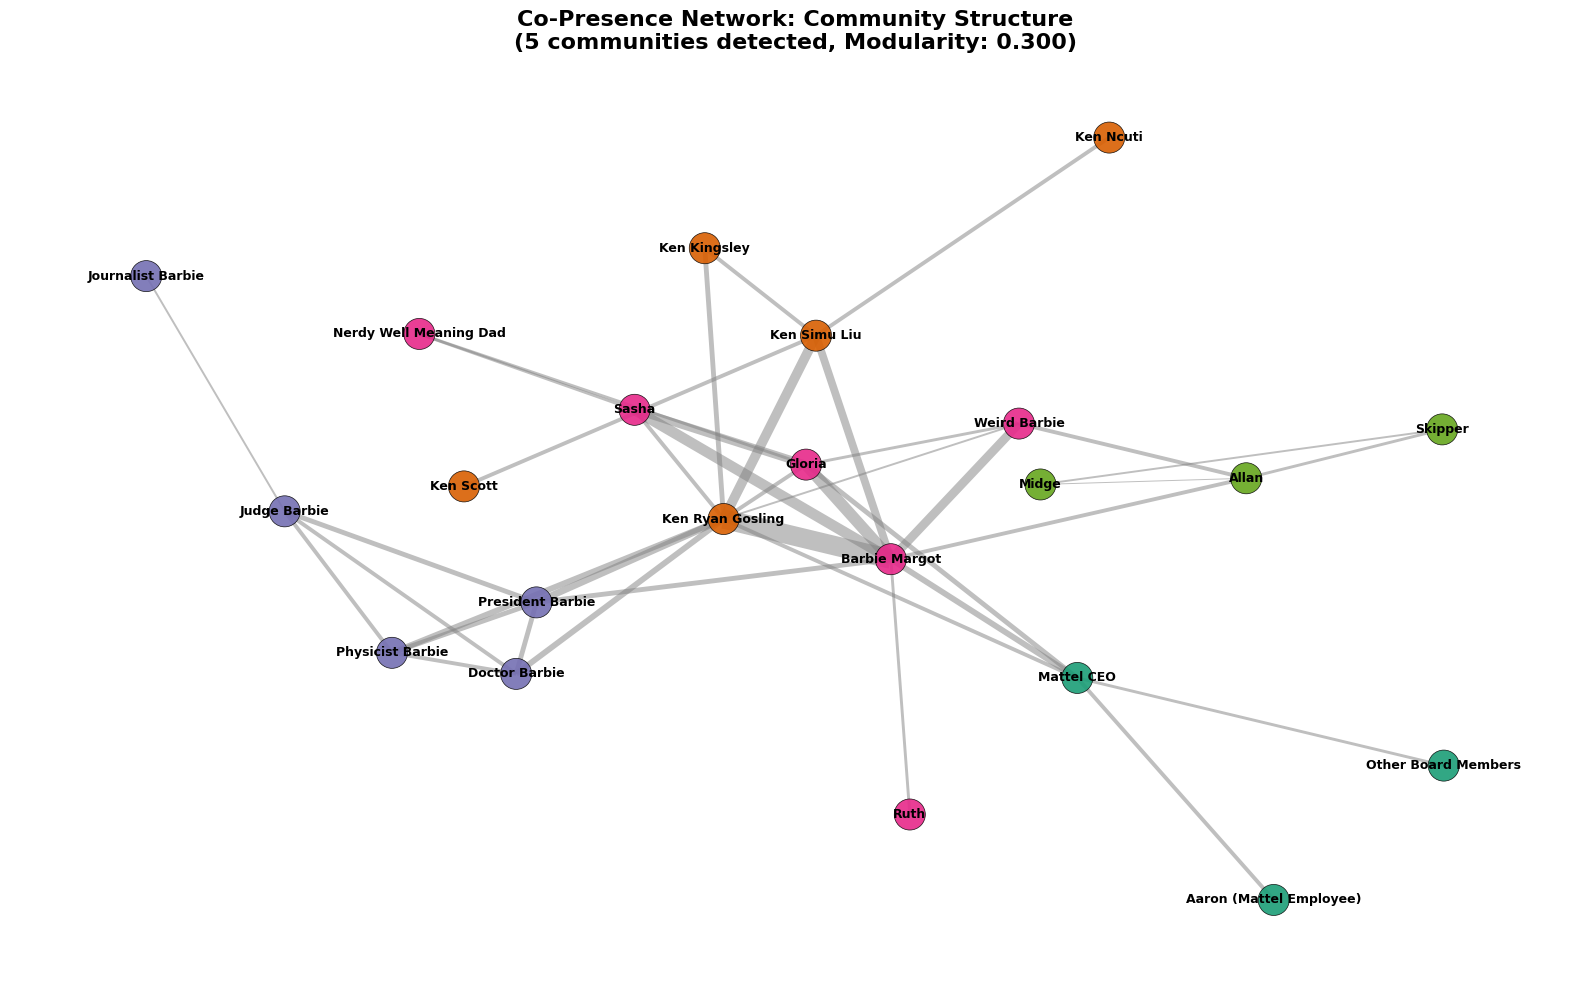

✓ Visualization saved: copresence_communities.png


In [ ]:
print("\n🎨 Creating community structure visualization...\n")
log_message("Generating community visualization", "INFO")

# Prepare visualization parameters
uniform_node_size = 500
edge_width_multiplier = 0.7
edge_weights = [d['Weight'] * edge_width_multiplier for u, v, d in G.edges(data=True)]

# Use updated matplotlib colormap method
cmap = matplotlib.colormaps.get_cmap('Dark2')
# Handle community count properly
if community_count <= 8:
    node_colors = [cmap(partition[node] / max(8, community_count)) for node in G.nodes()]
else:
    # For >8 communities, use a different colormap with more colors
    cmap = matplotlib.colormaps.get_cmap('tab20')
    node_colors = [cmap(partition[node] / community_count) for node in G.nodes()]

# Create layout
pos = nx.spring_layout(G, k=0.7, iterations=50, seed=42)

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Draw network
nx.draw_networkx_nodes(
    G, pos,
    node_size=uniform_node_size,
    node_color=node_colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5,
    ax=ax
)
nx.draw_networkx_edges(
    G, pos,
    width=edge_weights,
    alpha=0.5,
    edge_color='gray',
    ax=ax
)
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight='bold',
    font_color='black',
    ax=ax
)

plt.title(
    f"Co-Presence Network: Community Structure\n"
    f"({community_count} communities detected, Modularity: {modularity:.3f})",
    fontsize=16,
    fontweight='bold'
)
plt.axis('off')
plt.tight_layout()

# Save and display
saved_path = save_visualization(fig, 'copresence_communities', 'Community structure')
plt.show()
plt.close()

print(f"✓ Visualization saved: {saved_path.name}")

## Visualization 2: Filtered Network (Core Relationships)

### What This Cell Does:
Creates a simplified version showing only the **strongest relationships** (Weight > 2).

**Why Filter?**
- Removes one-off scene sharings
- Reveals the "narrative backbone" - recurring relationships that drive the plot
- Makes the structure clearer by reducing visual clutter

**Changes from Previous Visualization**:
- **Fewer edges** = Only sustained relationships
- **Node size** = Based on filtered strength (importance in core network)
- **Red edges** = Emphasizes these are the critical structural connections

**What Disappears?**
Characters/connections that vanish were only in 1-2 scenes together - they're not part of the main narrative arc.


🎨 Creating filtered network visualization (Weight > 2)...

[INFO] Generating filtered network visualization
[INFO] Filtered graph: 20 nodes, 35 edges
[SUCCESS] Saved visualization: copresence_filtered.png (Filtered core relationships)


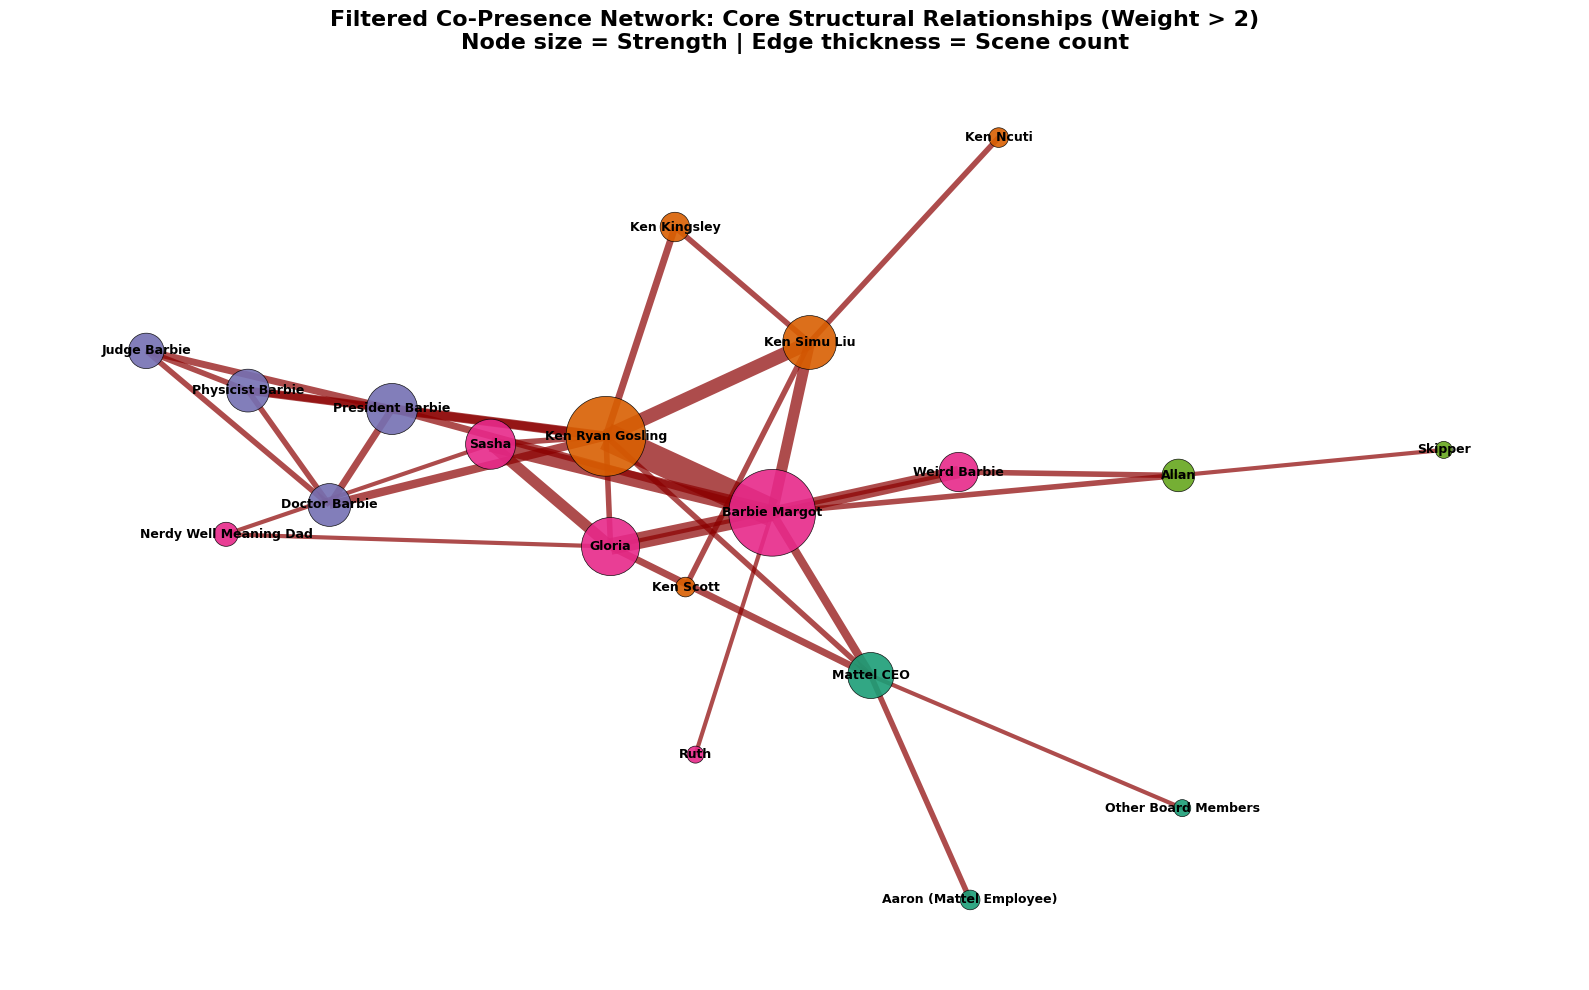

✓ Visualization saved: copresence_filtered.png


In [ ]:
print("\n🎨 Creating filtered network visualization (Weight > 2)...\n")
log_message("Generating filtered network visualization", "INFO")

# Create filtered graph
filtered_df = df_copresence[df_copresence['Weight'] > 2]
G_filtered = nx.from_pandas_edgelist(
    filtered_df,
    source='Source',
    target='Target',
    edge_attr='Weight'
)

log_message(f"Filtered graph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges", "INFO")

# Prepare visualization
filtered_node_sizes = [G_filtered.degree(node, weight='Weight') * 50 for node in G_filtered.nodes()]
filtered_edge_weights = [d['Weight'] * 1.0 for u, v, d in G_filtered.edges(data=True)]

# Use colors from partition (only for nodes in filtered graph)
filtered_node_colors = [cmap(partition[node] / max(8, community_count)) for node in G_filtered.nodes()]

# Create layout
pos_filtered = nx.spring_layout(G_filtered, k=0.7, iterations=50, seed=42)

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Draw network
nx.draw_networkx_nodes(
    G_filtered, pos_filtered,
    node_size=filtered_node_sizes,
    node_color=filtered_node_colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5,
    ax=ax
)
nx.draw_networkx_edges(
    G_filtered, pos_filtered,
    width=filtered_edge_weights,
    alpha=0.7,
    edge_color='darkred',
    ax=ax
)
nx.draw_networkx_labels(
    G_filtered, pos_filtered,
    font_size=9,
    font_weight='bold',
    font_color='black',
    ax=ax
)

plt.title(
    "Filtered Co-Presence Network: Core Structural Relationships (Weight > 2)\n"
    "Node size = Strength | Edge thickness = Scene count",
    fontsize=16,
    fontweight='bold'
)
plt.axis('off')
plt.tight_layout()

# Save and display
saved_path = save_visualization(fig, 'copresence_filtered', 'Filtered core relationships')
plt.show()
plt.close()

print(f"✓ Visualization saved: {saved_path.name}")

## Visualization 3: Betweenness Centrality

### What This Cell Does:
Shows which characters are the most important **bridges** in the network.

**Key Feature**:
- **Node size** = Betweenness centrality (bigger = more bridging)
- **Colors** = Still show communities

**What to Look For**:
1. **Large nodes within their community** = Internal leaders
2. **Large nodes between communities** = Plot catalysts who enable the story to move between different worlds/groups
3. **Small nodes** = May be central within tight groups but don't bridge to other parts of the network

**Story Interpretation**:
Characters with high betweenness are structurally positioned to:
- Facilitate plot developments
- Enable other characters to meet/interact
- Control flow of information between groups
- Cause narrative disruption if removed


🎨 Creating betweenness centrality visualization...

[INFO] Generating betweenness visualization
[SUCCESS] Saved visualization: copresence_betweenness.png (Betweenness centrality)


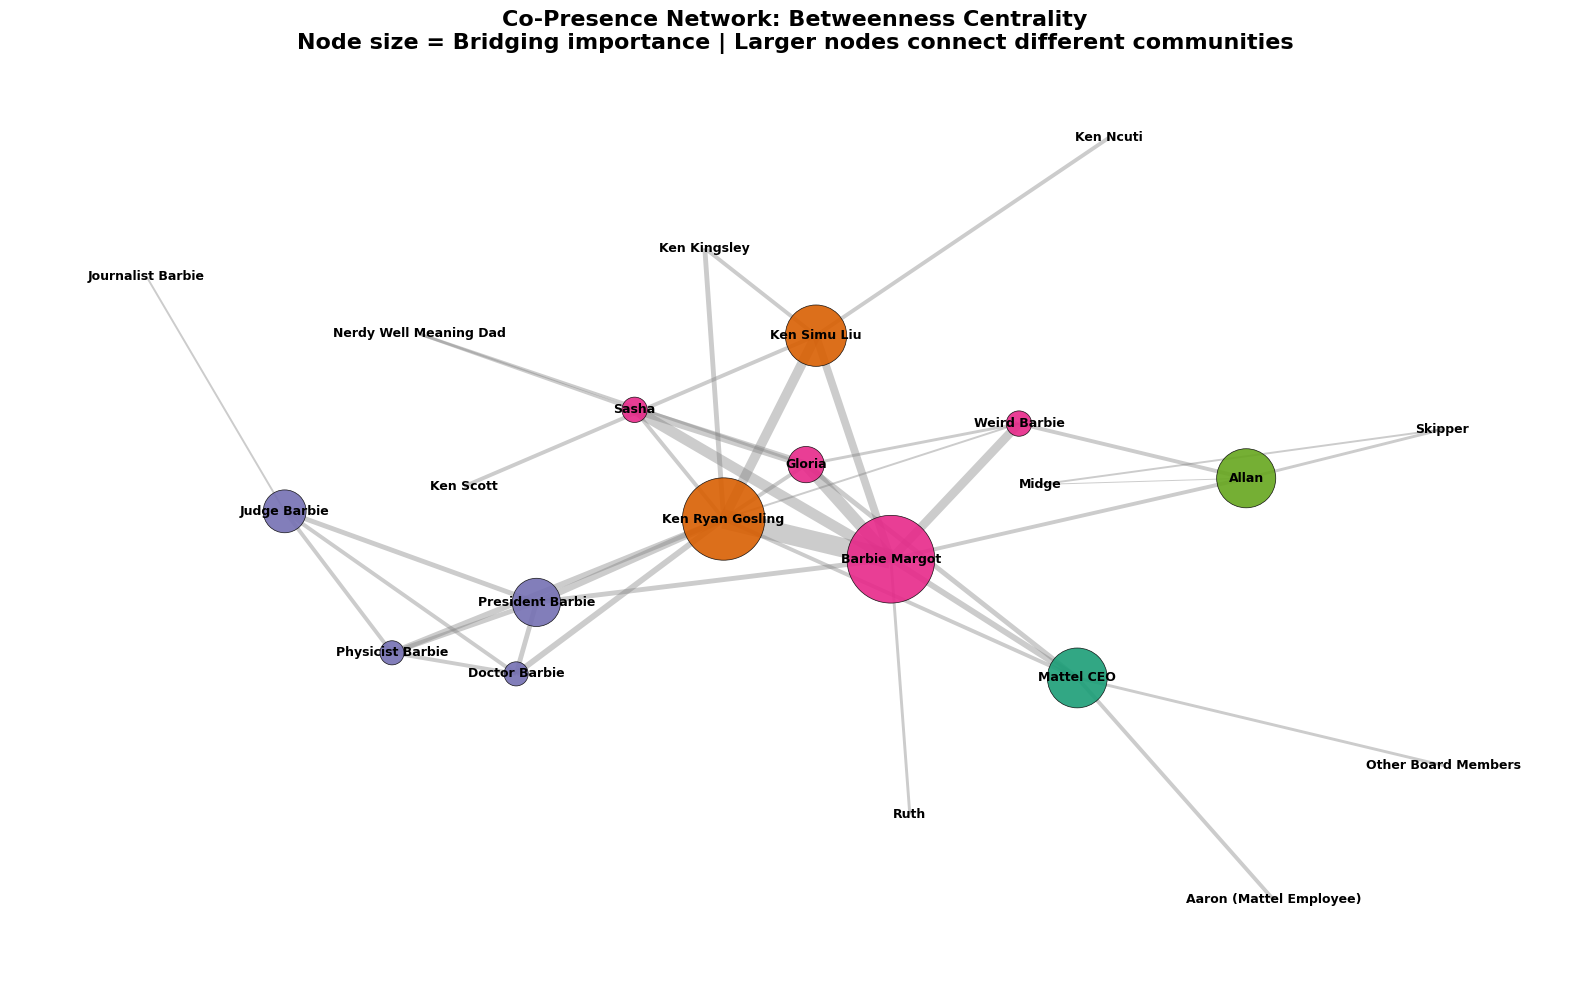

✓ Visualization saved: copresence_betweenness.png


In [ ]:
print("\n🎨 Creating betweenness centrality visualization...\n")
log_message("Generating betweenness visualization", "INFO")

# Prepare visualization
node_size_multiplier = 10000
node_sizes = [centrality_results['betweenness'][node] * node_size_multiplier for node in G.nodes()]
edge_weights_viz = [d['Weight'] * 0.7 for u, v, d in G.edges(data=True)]

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Draw network
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5,
    ax=ax
)
nx.draw_networkx_edges(
    G, pos,
    width=edge_weights_viz,
    alpha=0.4,
    edge_color='gray',
    ax=ax
)
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight='bold',
    font_color='black',
    ax=ax
)

plt.title(
    "Co-Presence Network: Betweenness Centrality\n"
    "Node size = Bridging importance | Larger nodes connect different communities",
    fontsize=16,
    fontweight='bold'
)
plt.axis('off')
plt.tight_layout()

# Save and display
saved_path = save_visualization(fig, 'copresence_betweenness', 'Betweenness centrality')
plt.show()
plt.close()

print(f"✓ Visualization saved: {saved_path.name}")

## Visualization 4: Strength (Weighted Degree)

### What This Cell Does:
Uses a **color gradient** to show total screentime (strength).

**Color Scale**:
- **Dark purple/blue** = Low total screentime
- **Bright yellow/green** = High total screentime

**Why Use Color Instead of Size?**
- Easier to compare multiple characters at once
- Can still see network structure clearly
- The color bar shows the exact range of values

**What This Reveals**:
- Who are the protagonists? (Brightest colors)
- Are there supporting characters with surprising amounts of screentime?
- Which communities have the most active members overall?
- Are the bridge characters also high in strength, or do they connect despite less screentime?


🎨 Creating strength (weighted degree) visualization...

[INFO] Generating strength visualization
[SUCCESS] Saved visualization: copresence_strength.png (Strength (weighted degree))


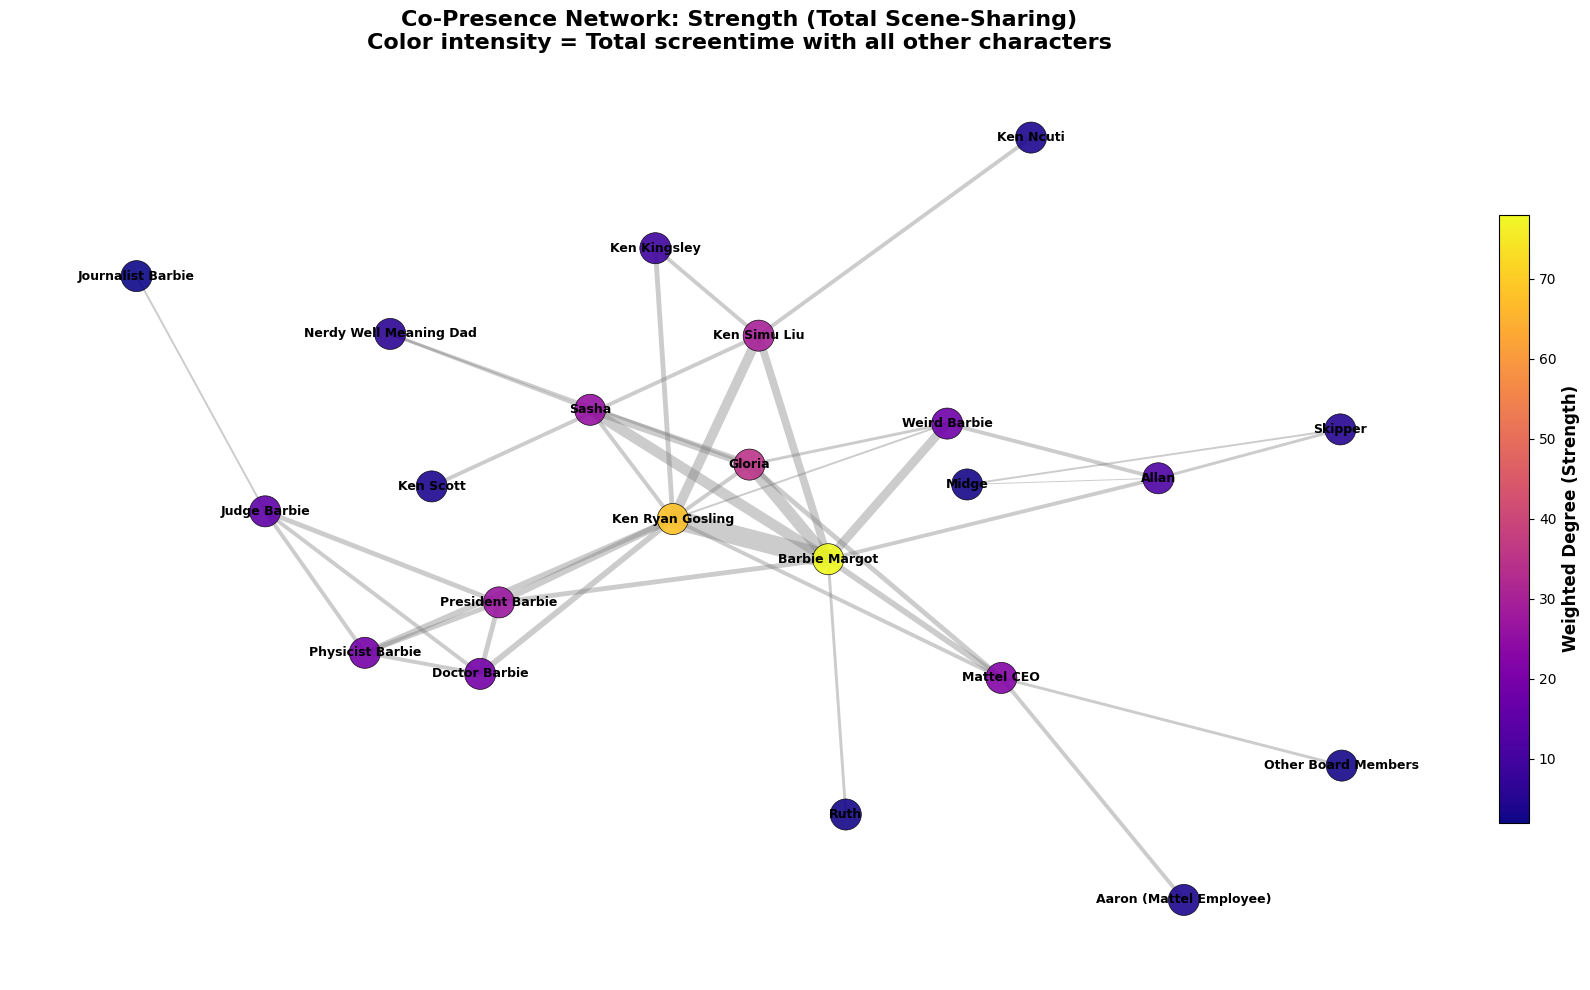

✓ Visualization saved: copresence_strength.png
[SUCCESS] Session 1 visualizations complete


In [ ]:
print("\n🎨 Creating strength (weighted degree) visualization...\n")
log_message("Generating strength visualization", "INFO")

# Prepare color mapping
strength_values = pd.Series(centrality_results['strength'])
norm = plt.Normalize(vmin=strength_values.min(), vmax=strength_values.max())
cmap_strength = plt.cm.plasma
node_colors_strength = [cmap_strength(norm(centrality_results['strength'][node])) for node in G.nodes()]

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Draw network
nx.draw_networkx_nodes(
    G, pos,
    node_size=500,
    node_color=node_colors_strength,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5,
    ax=ax
)
nx.draw_networkx_edges(
    G, pos,
    width=edge_weights_viz,
    alpha=0.4,
    edge_color='gray',
    ax=ax
)
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight='bold',
    font_color='black',
    ax=ax
)

plt.title(
    "Co-Presence Network: Strength (Total Scene-Sharing)\n"
    "Color intensity = Total screentime with all other characters",
    fontsize=16,
    fontweight='bold'
)
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_strength, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Weighted Degree (Strength)', fontsize=12, fontweight='bold')

plt.tight_layout()

# Save and display
saved_path = save_visualization(fig, 'copresence_strength', 'Strength (weighted degree)')
plt.show()
plt.close()

print(f"✓ Visualization saved: {saved_path.name}")
log_message("Session 1 visualizations complete", "SUCCESS")

# SESSION 2: Dialogue Network Analysis

## Building the Dialogue Network

### What This Cell Does:
Now we analyze a completely different type of relationship: **who speaks to whom**.

**Critical Difference**: This network is **DIRECTED**
- An arrow from A to B means "A speaks to B"
- A→B is different from B→A (one-way communication)
- Like Twitter follows (not mutual like Facebook friends)

**Why This Matters**:
- Someone can speak TO another person without being spoken to back (unreciprocated attention)
- Reveals power dynamics: who initiates? Who responds?
- Shows narrative focus: whose perspective drives conversations?

**New Metrics We'll Calculate**:
- **In-Degree**: How many people speak TO you (attention received)
- **Out-Degree**: How many people you speak TO (attention given)
- **Eigenvector Centrality**: Connected to influential speakers (prestige)

In [ ]:
print("\n" + "="*70)
print("💬 SESSION 2: DIALOGUE NETWORK ANALYSIS")
print("="*70)
log_message("Starting Session 2: Dialogue Network Analysis", "INFO")

# Create the DIRECTED graph
log_message("Creating dialogue network graph (directed)...", "INFO")
G_dialogue = nx.from_pandas_edgelist(
    df_dialogue,
    source='Source',
    target='Target',
    edge_attr='Weight',
    create_using=nx.DiGraph
)

# Verify graph creation
if G_dialogue.number_of_nodes() == 0:
    log_message("ERROR: Dialogue graph has no nodes!", "ERROR")
    raise ValueError("Failed to create dialogue graph - no nodes found")

print(f"\n✓ Directed dialogue graph created successfully!")
print(f"  - Nodes (characters): {G_dialogue.number_of_nodes()}")
print(f"  - Directed edges (conversations): {G_dialogue.number_of_edges()}")
print(f"  - Average in-degree: {sum(dict(G_dialogue.in_degree()).values()) / G_dialogue.number_of_nodes():.2f}")
print(f"  - Average out-degree: {sum(dict(G_dialogue.out_degree()).values()) / G_dialogue.number_of_nodes():.2f}")

# Check reciprocity
reciprocity = nx.overall_reciprocity(G_dialogue)
print(f"  - Reciprocity: {reciprocity:.3f}")
print(f"    (Probability that if A speaks to B, then B also speaks to A)")

log_message(f"Dialogue graph: {G_dialogue.number_of_nodes()} nodes, {G_dialogue.number_of_edges()} edges, reciprocity={reciprocity:.3f}", "SUCCESS")


💬 SESSION 2: DIALOGUE NETWORK ANALYSIS
[INFO] Starting Session 2: Dialogue Network Analysis
[INFO] Creating dialogue network graph (directed)...

✓ Directed dialogue graph created successfully!
  - Nodes (characters): 19
  - Directed edges (conversations): 38
  - Average in-degree: 2.00
  - Average out-degree: 2.00
  - Reciprocity: 0.632
    (Probability that if A speaks to B, then B also speaks to A)
[SUCCESS] Dialogue graph: 19 nodes, 38 edges, reciprocity=0.632


## Calculating Dialogue Centrality Metrics

### What This Cell Does:
Calculates directed network metrics that reveal communication patterns:

**1. In-Degree (Weighted)**
- Total dialogue lines directed AT this character
- **High in-degree** = Object of attention, authority figure
- "Everyone talks TO this person"

**2. Out-Degree (Weighted)**
- Total dialogue lines this character speaks TO others
- **High out-degree** = Initiator, driver of conversations
- "This person talks TO everyone"

**3. In/Out Ratio**
- Comparison of received vs. given attention
- **Ratio > 1** = Receives more than gives (high status)
- **Ratio < 1** = Gives more than receives (seeking attention/status)

**4. Eigenvector Centrality**
- Measures "prestige" - being spoken to BY important people
- Like being cited by Nobel Prize winners
- Can be high even with low degree if connected to hubs

In [ ]:
print("\n🔢 Calculating dialogue centrality metrics...\n")
log_message("Calculating dialogue centrality metrics", "INFO")

# Initialize results
dialogue_results = {}

# Progress bar
pbar = create_progress_bar(4, "Computing dialogue metrics")

# 1. In-Degree (weighted)
in_degree = dict(G_dialogue.in_degree(weight='Weight'))
dialogue_results['in_degree'] = in_degree
log_message("Calculated in-degree (dialogue received)", "SUCCESS")
pbar.update(1)

# 2. Out-Degree (weighted)
out_degree = dict(G_dialogue.out_degree(weight='Weight'))
dialogue_results['out_degree'] = out_degree
log_message("Calculated out-degree (dialogue given)", "SUCCESS")
pbar.update(1)

# 3. Eigenvector Centrality
try:
    eigenvector = nx.eigenvector_centrality(G_dialogue, weight='Weight', max_iter=1000)
    dialogue_results['eigenvector'] = eigenvector
    log_message("Calculated eigenvector centrality (prestige)", "SUCCESS")
except:
    log_message("Could not calculate eigenvector centrality", "WARNING")
    eigenvector = {node: 0 for node in G_dialogue.nodes()}
    dialogue_results['eigenvector'] = eigenvector
pbar.update(1)

# 4. PageRank (alternative prestige measure)
pagerank = nx.pagerank(G_dialogue, weight='Weight')
dialogue_results['pagerank'] = pagerank
log_message("Calculated PageRank (alternative prestige measure)", "SUCCESS")
pbar.update(1)
pbar.close()

# Create DataFrame
dialogue_centrality_df = pd.DataFrame({
    'Character': list(G_dialogue.nodes()),
    'Dialogue In-Degree': [in_degree.get(node, 0) for node in G_dialogue.nodes()],
    'Dialogue Out-Degree': [out_degree.get(node, 0) for node in G_dialogue.nodes()],
    'In/Out Ratio': [
        (in_degree.get(node, 0) / out_degree.get(node, 1)) if out_degree.get(node, 0) > 0 else 0
        for node in G_dialogue.nodes()
    ],
    'Dialogue Eigenvector': [eigenvector.get(node, 0) for node in G_dialogue.nodes()],
    'Dialogue PageRank': [pagerank.get(node, 0) for node in G_dialogue.nodes()]
}).sort_values(by='Dialogue In-Degree', ascending=False)

# Display results
print("\n" + "="*70)
print("📊 DIALOGUE CENTRALITY METRICS")
print("="*70)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(dialogue_centrality_df.to_string(index=False))

# Identify asymmetries
print("\n" + "="*70)
print("⚖️ ATTENTION ASYMMETRIES")
print("="*70)
print("\nCharacters with significantly more OUT than IN (seeking attention):")
attention_seekers = dialogue_centrality_df[
    dialogue_centrality_df['Dialogue Out-Degree'] > dialogue_centrality_df['Dialogue In-Degree'] * 1.2
][['Character', 'Dialogue Out-Degree', 'Dialogue In-Degree', 'In/Out Ratio']]
if len(attention_seekers) > 0:
    print(attention_seekers.to_string(index=False))
else:
    print("  None found")

print("\nCharacters with significantly more IN than OUT (receiving attention):")
attention_receivers = dialogue_centrality_df[
    dialogue_centrality_df['Dialogue In-Degree'] > dialogue_centrality_df['Dialogue Out-Degree'] * 1.2
][['Character', 'Dialogue In-Degree', 'Dialogue Out-Degree', 'In/Out Ratio']]
if len(attention_receivers) > 0:
    print(attention_receivers.to_string(index=False))
else:
    print("  None found")

# Save to CSV
dialogue_centrality_df.to_csv(output_dir / 'data' / 'dialogue_centrality.csv', index=False)
log_message("Dialogue centrality data saved", "SUCCESS")


🔢 Calculating dialogue centrality metrics...

[INFO] Calculating dialogue centrality metrics


Computing dialogue metrics:   0%|          | 0/4 [00:00<?]

[SUCCESS] Calculated in-degree (dialogue received)
[SUCCESS] Calculated out-degree (dialogue given)
[SUCCESS] Calculated eigenvector centrality (prestige)
[SUCCESS] Calculated PageRank (alternative prestige measure)

📊 DIALOGUE CENTRALITY METRICS
              Character  Dialogue In-Degree  Dialogue Out-Degree  In/Out Ratio  Dialogue Eigenvector  Dialogue PageRank
          Barbie Margot                 115                  110         1.045                 0.697              0.234
       Ken Ryan Gosling                  50                   61         0.820                 0.479              0.128
                 Gloria                  38                   49         0.776                 0.366              0.097
                  Sasha                  25                   18         1.389                 0.262              0.056
           Weird Barbie                  16                   20         0.800                 0.160              0.058
             Mattel CEO          

## Visualization 5: Directed Dialogue Network

### What This Cell Does:
Shows the dialogue network with **arrows** indicating direction of communication.

**How to Read This**:
- **Arrow points FROM speaker TO addressee**
- **Arrow thickness** = Number of dialogue lines
- **Two arrows between characters** = Mutual conversation
- **One arrow** = One-way communication

**What to Look For**:
1. **Hub characters with many incoming arrows** = Central figures everyone addresses
2. **Characters with many outgoing arrows** = Initiators of dialogue
3. **Unreciprocated arrows** = Asymmetric relationships (status differences)
4. **Clusters of mutual arrows** = Conversational groups
5. **Peripheral characters with few arrows** = Minor roles or observers


🎨 Creating directed dialogue network visualization...

[INFO] Generating directed dialogue visualization
[SUCCESS] Saved visualization: dialogue_directed.png (Directed dialogue network)


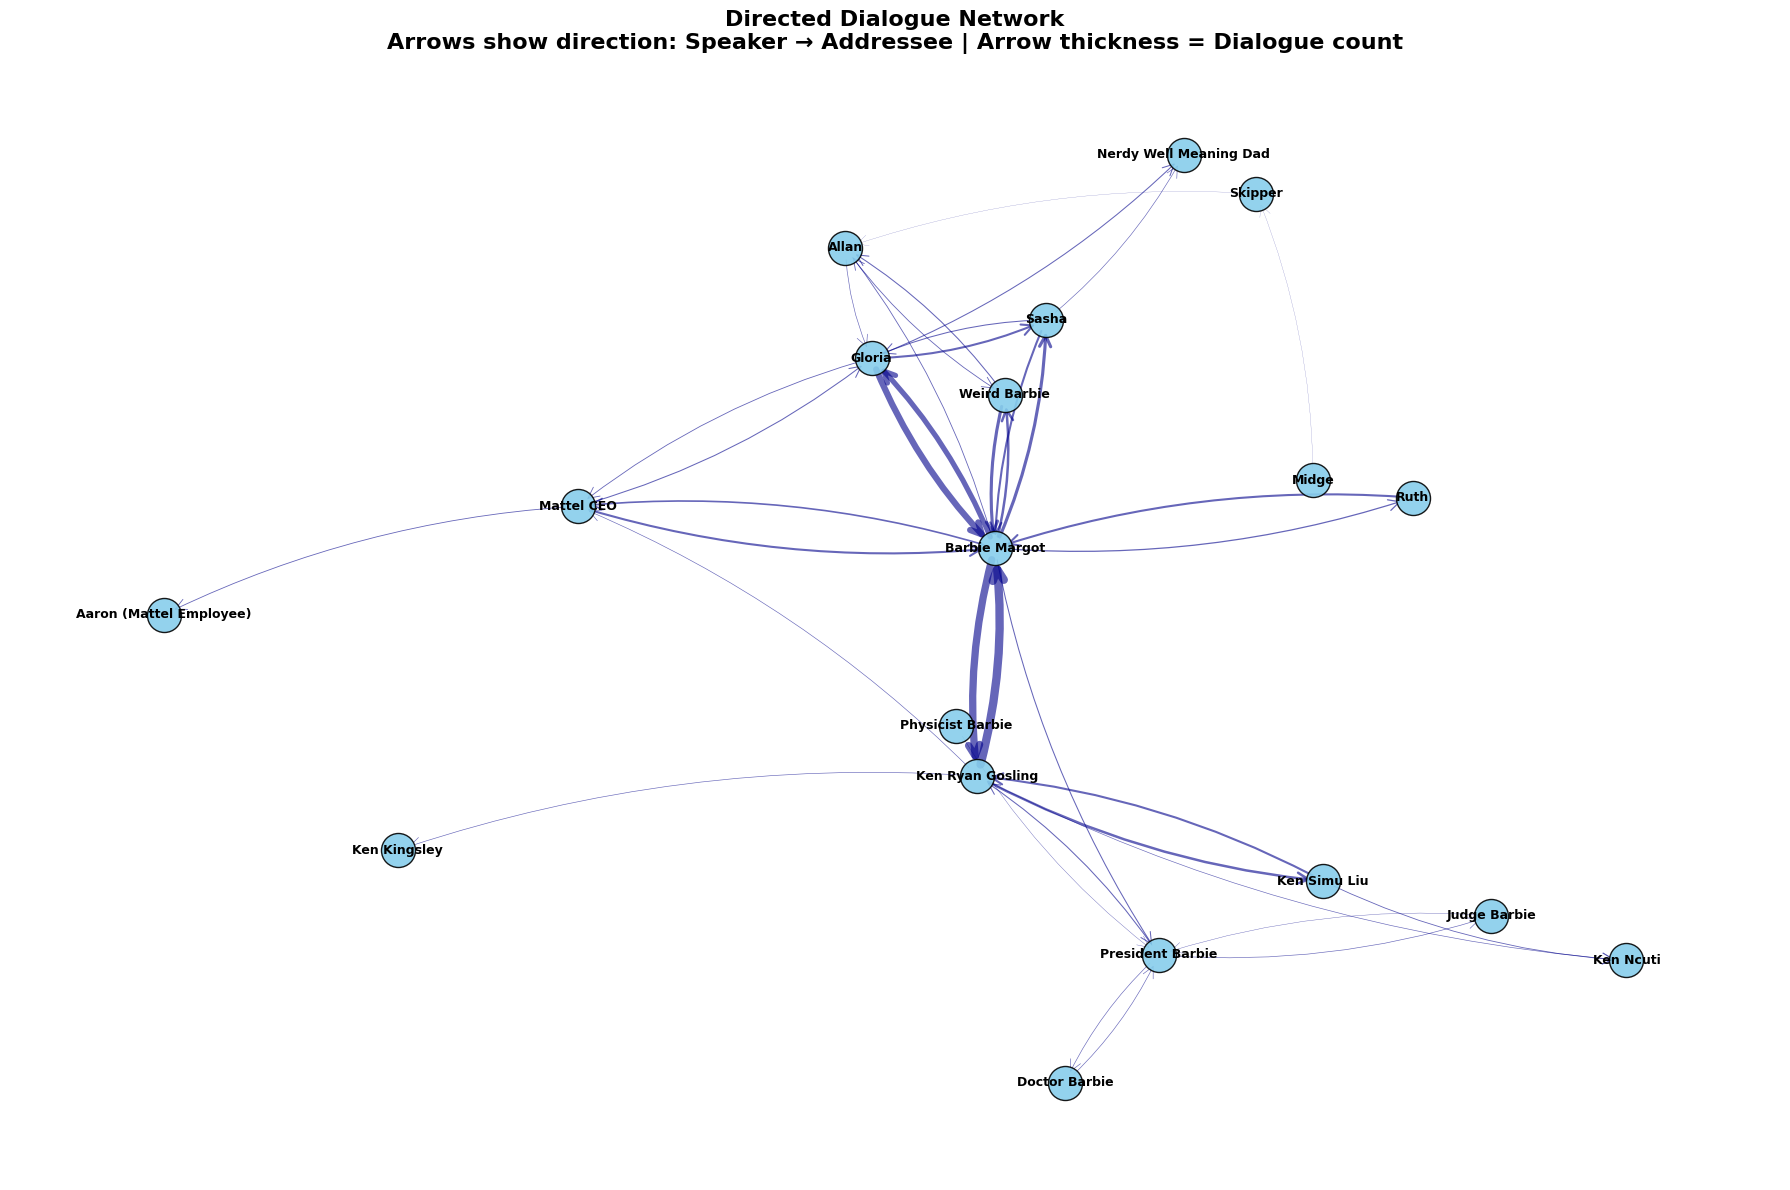

✓ Visualization saved: dialogue_directed.png


In [ ]:
print("\n🎨 Creating directed dialogue network visualization...\n")
log_message("Generating directed dialogue visualization", "INFO")

# Prepare visualization
edge_weights_dialogue = [d['Weight'] * 0.15 for u, v, d in G_dialogue.edges(data=True)]
uniform_node_size = 600

# Create layout
pos_dialogue = nx.spring_layout(G_dialogue, k=0.6, iterations=50, seed=42)

# Create figure
fig, ax = plt.subplots(figsize=(18, 12))

# Draw edges with arrows
nx.draw_networkx_edges(
    G_dialogue, pos_dialogue,
    width=edge_weights_dialogue,
    alpha=0.6,
    edge_color='darkblue',
    arrowstyle='->',
    arrowsize=20,
    connectionstyle='arc3,rad=0.1',
    ax=ax
)

# Draw nodes
nx.draw_networkx_nodes(
    G_dialogue, pos_dialogue,
    node_size=uniform_node_size,
    node_color='skyblue',
    alpha=0.9,
    edgecolors='black',
    linewidths=1.0,
    ax=ax
)

# Draw labels
nx.draw_networkx_labels(
    G_dialogue, pos_dialogue,
    font_size=9,
    font_weight='bold',
    font_color='black',
    ax=ax
)

plt.title(
    "Directed Dialogue Network\n"
    "Arrows show direction: Speaker → Addressee | Arrow thickness = Dialogue count",
    fontsize=16,
    fontweight='bold'
)
plt.axis('off')
plt.tight_layout()

# Save and display
saved_path = save_visualization(fig, 'dialogue_directed', 'Directed dialogue network')
plt.show()
plt.close()

print(f"✓ Visualization saved: {saved_path.name}")

## Visualization 6: In-Degree vs Out-Degree Comparison

### What This Cell Does:
Creates a scatter plot comparing how much each character speaks (out-degree) vs. how much they're spoken to (in-degree).

**How to Read This Plot**:
- **X-axis** = Out-Degree (dialogue given)
- **Y-axis** = In-Degree (dialogue received)
- **Diagonal line** = Perfect balance (give as much as receive)
- **Above line** = Receive more than give (high status)
- **Below line** = Give more than receive (seeking status)
- **Size** = Total degree (overall dialogue involvement)

**Quadrant Interpretation**:
1. **Top-Right** = Dialogue hubs (high both directions)
2. **Top-Left** = Addressed more than speaking (authority/object of attention)
3. **Bottom-Right** = Speaking more than addressed (initiators/status-seekers)
4. **Bottom-Left** = Low dialogue involvement (peripheral characters)


🎨 Creating in-degree vs out-degree scatter plot...

[INFO] Generating degree comparison visualization
[SUCCESS] Saved visualization: dialogue_in_vs_out.png (In-degree vs out-degree)


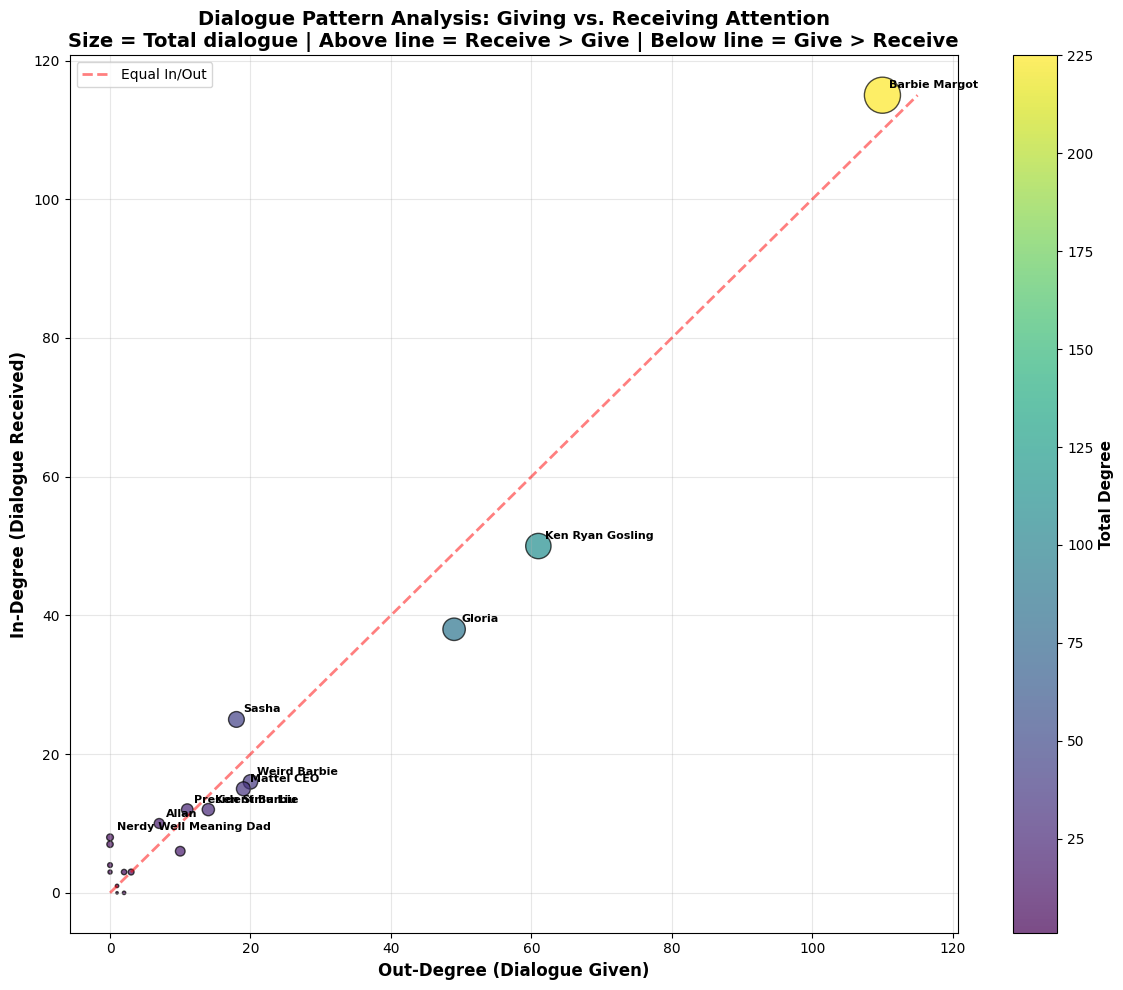

✓ Visualization saved: dialogue_in_vs_out.png
[SUCCESS] Session 2 visualizations complete


In [ ]:
print("\n🎨 Creating in-degree vs out-degree scatter plot...\n")
log_message("Generating degree comparison visualization", "INFO")

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Prepare data
in_deg_values = dialogue_centrality_df['Dialogue In-Degree'].values
out_deg_values = dialogue_centrality_df['Dialogue Out-Degree'].values
total_deg = in_deg_values + out_deg_values

# Create scatter plot
scatter = ax.scatter(
    out_deg_values,
    in_deg_values,
    s=total_deg * 3,
    c=total_deg,
    cmap='viridis',
    alpha=0.7,
    edgecolors='black',
    linewidths=1
)

# Add diagonal line (equal in and out)
max_val = max(max(in_deg_values), max(out_deg_values))
ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2, label='Equal In/Out')

# Add labels for top characters
for idx, row in dialogue_centrality_df.head(10).iterrows():
    ax.annotate(
        row['Character'],
        (row['Dialogue Out-Degree'], row['Dialogue In-Degree']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        fontweight='bold'
    )

# Formatting
ax.set_xlabel('Out-Degree (Dialogue Given)', fontsize=12, fontweight='bold')
ax.set_ylabel('In-Degree (Dialogue Received)', fontsize=12, fontweight='bold')
ax.set_title(
    'Dialogue Pattern Analysis: Giving vs. Receiving Attention\n'
    'Size = Total dialogue | Above line = Receive > Give | Below line = Give > Receive',
    fontsize=14,
    fontweight='bold'
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Total Degree', fontsize=11, fontweight='bold')

plt.tight_layout()

# Save and display
saved_path = save_visualization(fig, 'dialogue_in_vs_out', 'In-degree vs out-degree')
plt.show()
plt.close()

print(f"✓ Visualization saved: {saved_path.name}")
log_message("Session 2 visualizations complete", "SUCCESS")

# SESSION 3: Comprehensive Comparison & Analysis

## Merging Co-Presence and Dialogue Data

### What This Cell Does:
Combines all metrics from both networks into one comprehensive table for comparison.

**Why Compare?**
The relationship between physical co-presence and dialogue reveals:

1. **Silent Witnesses**: High co-presence, low dialogue
   - Present in scenes but don't speak much
   - Observers or background characters

2. **Verbose Connectors**: Low co-presence, high dialogue
   - Don't appear often but talk a lot when they do
   - Concentrated impact

3. **Consistent Hubs**: High in both
   - Protagonists who both appear frequently AND drive dialogue
   - Narrative engines

4. **Structural Catalysts**: High betweenness in co-presence, high dialogue metrics
   - Bridge characters who both connect groups AND facilitate communication
   - Essential for plot progression

In [ ]:
print("\n" + "="*70)
print("📊 SESSION 3: COMPREHENSIVE COMPARISON & ANALYSIS")
print("="*70)
log_message("Starting Session 3: Comprehensive Comparison", "INFO")

# Merge dataframes
log_message("Merging co-presence and dialogue metrics", "INFO")
full_centrality_df = pd.merge(
    co_presence_df,
    dialogue_centrality_df,
    on='Character',
    how='outer'
).fillna(0)

# Sort by co-presence strength
full_centrality_df = full_centrality_df.sort_values(by='Co-Presence Strength', ascending=False)

# Display comprehensive table
print("\n" + "="*70)
print("📋 COMPREHENSIVE CENTRALITY COMPARISON")
print("="*70)
print("\nAll metrics for all characters:\n")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(full_centrality_df.to_string(index=False))

# Identify interesting patterns
print("\n" + "="*70)
print("🔍 STRUCTURAL ROLE ANALYSIS")
print("="*70)

# 1. Silent Witnesses
print("\n1. SILENT WITNESSES (High co-presence, low dialogue):")
silent_witnesses = full_centrality_df[
    (full_centrality_df['Co-Presence Strength'] > full_centrality_df['Co-Presence Strength'].mean()) &
    ((full_centrality_df['Dialogue In-Degree'] + full_centrality_df['Dialogue Out-Degree']) <
     (full_centrality_df['Dialogue In-Degree'] + full_centrality_df['Dialogue Out-Degree']).mean())
][['Character', 'Co-Presence Strength', 'Dialogue In-Degree', 'Dialogue Out-Degree']]
if len(silent_witnesses) > 0:
    print(silent_witnesses.to_string(index=False))
else:
    print("  None identified")

# 2. Status Seekers
print("\n2. STATUS SEEKERS (Out-degree >> In-degree):")
status_seekers = full_centrality_df[
    full_centrality_df['Dialogue Out-Degree'] > full_centrality_df['Dialogue In-Degree'] * 1.3
][['Character', 'Dialogue Out-Degree', 'Dialogue In-Degree', 'In/Out Ratio']]
if len(status_seekers) > 0:
    print(status_seekers.to_string(index=False))
else:
    print("  None identified")

# 3. Structural Catalysts
print("\n3. STRUCTURAL CATALYSTS (High betweenness AND dialogue):")
catalysts = full_centrality_df[
    (full_centrality_df['Co-Presence Betweenness'] > full_centrality_df['Co-Presence Betweenness'].mean()) &
    ((full_centrality_df['Dialogue In-Degree'] + full_centrality_df['Dialogue Out-Degree']) >
     (full_centrality_df['Dialogue In-Degree'] + full_centrality_df['Dialogue Out-Degree']).mean())
][['Character', 'Co-Presence Betweenness', 'Dialogue In-Degree', 'Dialogue Out-Degree']]
if len(catalysts) > 0:
    print(catalysts.to_string(index=False))
else:
    print("  None identified")

# 4. Protagonists
print("\n4. PROTAGONISTS (Top 3 in co-presence strength):")
protagonists = full_centrality_df.head(3)[[
    'Character', 'Co-Presence Strength', 'Co-Presence Betweenness',
    'Dialogue In-Degree', 'Dialogue Out-Degree', 'Dialogue Eigenvector'
]]
print(protagonists.to_string(index=False))

# Save comprehensive data
full_centrality_df.to_csv(output_dir / 'data' / 'comprehensive_centrality.csv', index=False)
log_message("Comprehensive centrality data saved", "SUCCESS")


📊 SESSION 3: COMPREHENSIVE COMPARISON & ANALYSIS
[INFO] Starting Session 3: Comprehensive Comparison
[INFO] Merging co-presence and dialogue metrics

📋 COMPREHENSIVE CENTRALITY COMPARISON

All metrics for all characters:

              Character  Co-Presence Strength  Co-Presence Betweenness  Co-Presence Closeness  Community  Dialogue In-Degree  Dialogue Out-Degree  In/Out Ratio  Dialogue Eigenvector  Dialogue PageRank
          Barbie Margot                    78                    0.399                  0.618          3             115.000              110.000         1.045                 0.697              0.234
       Ken Ryan Gosling                    68                    0.352                  0.600          1              50.000               61.000         0.820                 0.479              0.128
                 Gloria                    35                    0.068                  0.488          3              38.000               49.000         0.776               

## Visualization 7: Dual-Metric Comparison

### What This Cell Does:
Creates a scatter plot comparing co-presence strength (x-axis) vs. dialogue degree (y-axis).

**What This Reveals**:
- **Top-right** = Protagonists (high in everything)
- **Top-left** = Talkers with limited presence
- **Bottom-right** = Present but quiet (silent witnesses)
- **Bottom-left** = Minor characters

**The Ideal Line**:
Characters near the diagonal have proportional presence and dialogue. Characters far from it have interesting asymmetries worth examining.


🎨 Creating dual-metric comparison visualization...

[INFO] Generating co-presence vs dialogue comparison
[SUCCESS] Saved visualization: comparison_presence_vs_dialogue.png (Presence vs dialogue)


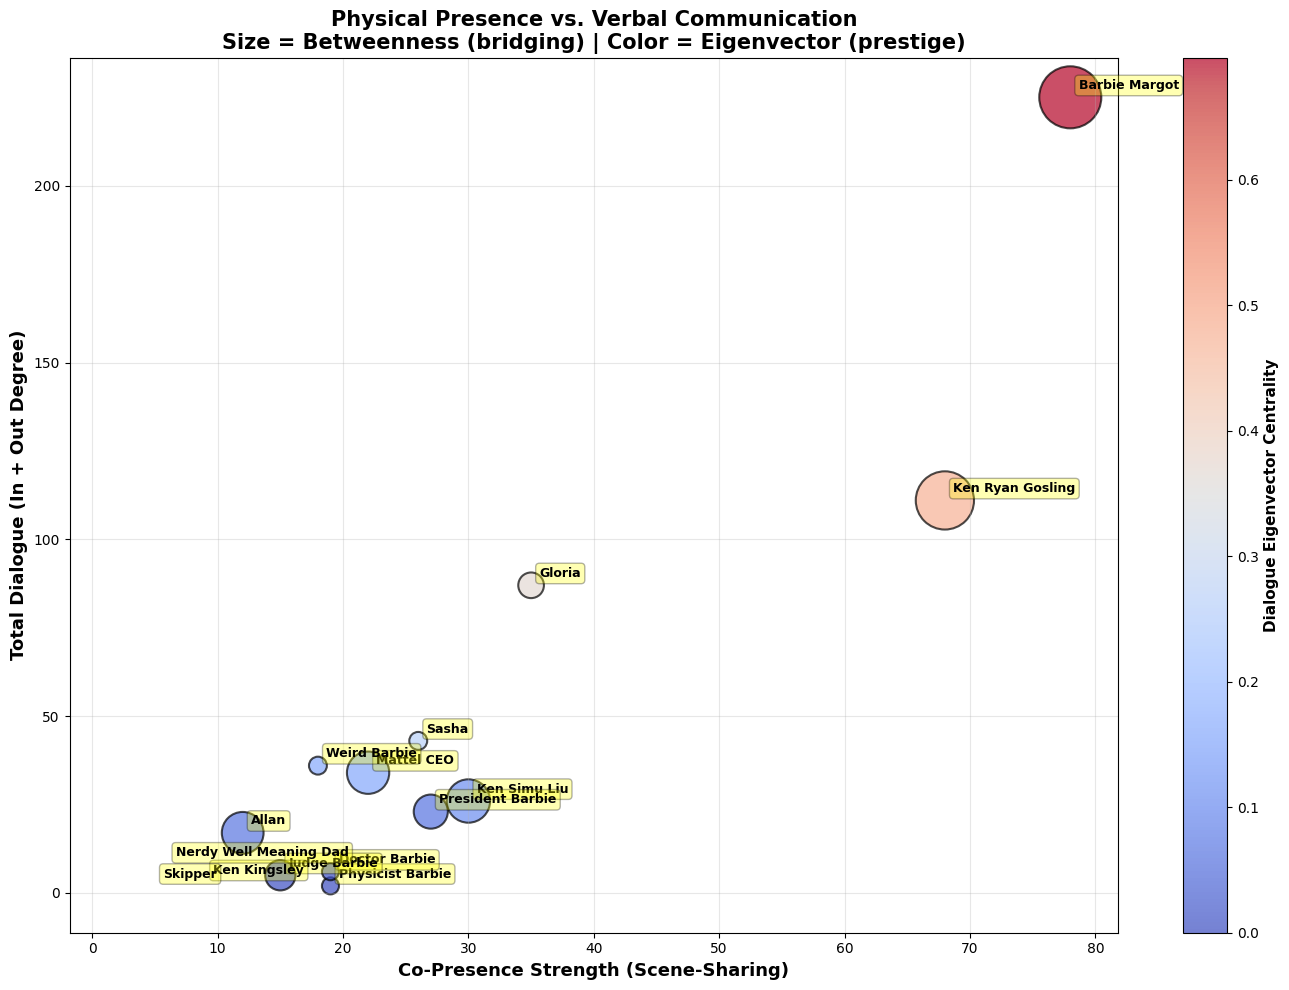

✓ Visualization saved: comparison_presence_vs_dialogue.png


In [ ]:
print("\n🎨 Creating dual-metric comparison visualization...\n")
log_message("Generating co-presence vs dialogue comparison", "INFO")

# Prepare data
full_centrality_df['Total Dialogue'] = (
    full_centrality_df['Dialogue In-Degree'] + full_centrality_df['Dialogue Out-Degree']
)

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot
scatter = ax.scatter(
    full_centrality_df['Co-Presence Strength'],
    full_centrality_df['Total Dialogue'],
    s=full_centrality_df['Co-Presence Betweenness'] * 5000,
    c=full_centrality_df['Dialogue Eigenvector'],
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='black',
    linewidths=1.5
)

# Add labels for significant characters
for idx, row in full_centrality_df.head(15).iterrows():
    ax.annotate(
        row['Character'],
        (row['Co-Presence Strength'], row['Total Dialogue']),
        xytext=(6, 6),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3)
    )

# Formatting
ax.set_xlabel('Co-Presence Strength (Scene-Sharing)', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Dialogue (In + Out Degree)', fontsize=13, fontweight='bold')
ax.set_title(
    'Physical Presence vs. Verbal Communication\n'
    'Size = Betweenness (bridging) | Color = Eigenvector (prestige)',
    fontsize=15,
    fontweight='bold'
)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Dialogue Eigenvector Centrality', fontsize=11, fontweight='bold')

plt.tight_layout()

# Save and display
saved_path = save_visualization(fig, 'comparison_presence_vs_dialogue', 'Presence vs dialogue')
plt.show()
plt.close()

print(f"✓ Visualization saved: {saved_path.name}")

## Generating JSON Summary

### What This Cell Does:
Creates a structured JSON file containing all key findings and metrics. This is useful for:
- Importing into other programs
- Creating automated reports
- Archiving results
- Comparing different screenplay analyses

JSON is a standard format for storing structured data that both humans and computers can read.

In [ ]:
print("\n📝 Generating JSON summary...\n")
log_message("Creating JSON summary of analysis", "INFO")

# Create comprehensive summary
summary = {
    'metadata': {
        'analysis_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'data_source': 'Demo Data (Barbie Screenplay)' if not USE_UPLOADED_DATA else 'User Uploaded Data',
        'output_directory': str(output_dir.absolute())
    },
    'network_statistics': {
        'co_presence': {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': float(nx.density(G)),
            'is_connected': nx.is_connected(G),
            'transitivity': float(transitivity),
            'avg_shortest_path': float(avg_shortest_path) if isinstance(avg_shortest_path, (int, float)) else None,
            'max_clique_size': int(max_clique_size),
            'num_communities': int(community_count),
            'modularity': float(modularity)
        },
        'dialogue': {
            'num_nodes': G_dialogue.number_of_nodes(),
            'num_edges': G_dialogue.number_of_edges(),
            'density': float(nx.density(G_dialogue)),
            'reciprocity': float(reciprocity)
        }
    },
    'top_characters': {
        'by_copresence_strength': full_centrality_df.nlargest(5, 'Co-Presence Strength')[['Character', 'Co-Presence Strength']].to_dict('records'),
        'by_betweenness': full_centrality_df.nlargest(5, 'Co-Presence Betweenness')[['Character', 'Co-Presence Betweenness']].to_dict('records'),
        'by_dialogue_in': full_centrality_df.nlargest(5, 'Dialogue In-Degree')[['Character', 'Dialogue In-Degree']].to_dict('records'),
        'by_dialogue_out': full_centrality_df.nlargest(5, 'Dialogue Out-Degree')[['Character', 'Dialogue Out-Degree']].to_dict('records'),
        'by_eigenvector': full_centrality_df.nlargest(5, 'Dialogue Eigenvector')[['Character', 'Dialogue Eigenvector']].to_dict('records')
    },
    'structural_roles': {
        'silent_witnesses': silent_witnesses['Character'].tolist() if len(silent_witnesses) > 0 else [],
        'status_seekers': status_seekers['Character'].tolist() if len(status_seekers) > 0 else [],
        'structural_catalysts': catalysts['Character'].tolist() if len(catalysts) > 0 else [],
        'protagonists': protagonists['Character'].tolist()
    },
    'communities': community_data['communities']
}

# Save JSON
json_path = output_dir / 'data' / 'analysis_summary.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

log_message(f"JSON summary saved: {json_path.name}", "SUCCESS")
print(f"✓ JSON summary saved: {json_path}")
print(f"\n📄 Summary contains:")
print(f"  - Network statistics for both graphs")
print(f"  - Top 5 characters by each centrality metric")
print(f"  - Identified structural roles")
print(f"  - Community membership")


📝 Generating JSON summary...

[INFO] Creating JSON summary of analysis
[SUCCESS] JSON summary saved: analysis_summary.json
✓ JSON summary saved: network_analysis_outputs/data/analysis_summary.json

📄 Summary contains:
  - Network statistics for both graphs
  - Top 5 characters by each centrality metric
  - Identified structural roles
  - Community membership


## Generating PDF Report

### What This Cell Does:
Creates a comprehensive PDF report that includes:
- Executive summary of findings
- All visualizations
- Key metrics and tables
- Interpretation of results

This PDF is designed for human readers and can be shared with others who don't have access to the notebook.

In [ ]:
print("\n📄 Generating PDF report...\n")
log_message("Creating PDF report", "INFO")

# Create PDF
pdf_path = output_dir / 'Network_Analysis_Report.pdf'
doc = SimpleDocTemplate(
    str(pdf_path),
    pagesize=letter,
    topMargin=0.75*inch,
    bottomMargin=0.75*inch
)

# Styles
styles = getSampleStyleSheet()
title_style = ParagraphStyle(
    'CustomTitle',
    parent=styles['Heading1'],
    fontSize=24,
    textColor=colors.HexColor('#1f4788'),
    spaceAfter=30,
    alignment=TA_CENTER,
    fontName='Helvetica-Bold'
)
heading_style = ParagraphStyle(
    'CustomHeading',
    parent=styles['Heading2'],
    fontSize=16,
    textColor=colors.HexColor('#2c5f96'),
    spaceAfter=12,
    fontName='Helvetica-Bold'
)
normal_style = styles['Normal']

# Build content
story = []

# Title page
story.append(Spacer(1, 1*inch))
story.append(Paragraph("Network Analysis Report", title_style))
story.append(Spacer(1, 0.3*inch))
story.append(Paragraph(
    f"Analysis Date: {datetime.datetime.now().strftime('%B %d, %Y')}",
    ParagraphStyle('Subtitle', parent=normal_style, fontSize=12, alignment=TA_CENTER)
))
story.append(Spacer(1, 0.5*inch))

# Executive Summary
story.append(Paragraph("Executive Summary", heading_style))
summary_text = f"""
This report presents a comprehensive network analysis of character relationships in the screenplay.
The analysis examines two distinct types of networks: co-presence (who shares scenes) and dialogue
(who speaks to whom).<br/><br/>

<b>Key Findings:</b><br/>
• Co-Presence Network: {G.number_of_nodes()} characters, {G.number_of_edges()} relationships<br/>
• Dialogue Network: {G_dialogue.number_of_nodes()} characters, {G_dialogue.number_of_edges()} directed conversations<br/>
• Detected Communities: {community_count} distinct groups (Modularity: {modularity:.3f})<br/>
• Network Transitivity: {transitivity:.3f} (measures clustering)<br/>
• Dialogue Reciprocity: {reciprocity:.3f} (mutual conversation probability)<br/><br/>

<b>Top 3 Characters by Co-Presence:</b><br/>
1. {protagonists.iloc[0]['Character']}<br/>
2. {protagonists.iloc[1]['Character']}<br/>
3. {protagonists.iloc[2]['Character']}<br/>
"""
story.append(Paragraph(summary_text, normal_style))
story.append(PageBreak())

# Section 1: Co-Presence Analysis
story.append(Paragraph("Section 1: Co-Presence Network Analysis", heading_style))
story.append(Paragraph(
    "The co-presence network maps which characters share scenes together. "
    "This reveals the screenplay's structural decisions about physical proximity and presence.",
    normal_style
))
story.append(Spacer(1, 0.2*inch))

# Add visualizations
viz_files = [
    ('copresence_communities', 'Community Structure'),
    ('copresence_filtered', 'Core Relationships (Filtered)'),
    ('copresence_betweenness', 'Betweenness Centrality'),
    ('copresence_strength', 'Strength (Weighted Degree)')
]

for viz_file, caption in viz_files:
    img_path = output_dir / 'visualizations' / f'{viz_file}.png'
    if img_path.exists():
        story.append(Paragraph(f"<b>{caption}</b>", normal_style))
        story.append(Spacer(1, 0.1*inch))
        story.append(Image(str(img_path), width=6*inch, height=3.75*inch))
        story.append(Spacer(1, 0.3*inch))
        if viz_file != viz_files[-1][0]:
            story.append(PageBreak())

story.append(PageBreak())

# Section 2: Dialogue Analysis
story.append(Paragraph("Section 2: Dialogue Network Analysis", heading_style))
story.append(Paragraph(
    "The dialogue network is directed, showing who speaks to whom. "
    "This reveals communication patterns, power dynamics, and narrative focus.",
    normal_style
))
story.append(Spacer(1, 0.2*inch))

dialogue_viz_files = [
    ('dialogue_directed', 'Directed Dialogue Network'),
    ('dialogue_in_vs_out', 'In-Degree vs Out-Degree Analysis')
]

for viz_file, caption in dialogue_viz_files:
    img_path = output_dir / 'visualizations' / f'{viz_file}.png'
    if img_path.exists():
        story.append(Paragraph(f"<b>{caption}</b>", normal_style))
        story.append(Spacer(1, 0.1*inch))
        story.append(Image(str(img_path), width=6*inch, height=3.75*inch))
        story.append(Spacer(1, 0.3*inch))
        if viz_file != dialogue_viz_files[-1][0]:
            story.append(PageBreak())

story.append(PageBreak())

# Section 3: Comparison
story.append(Paragraph("Section 3: Comprehensive Comparison", heading_style))
story.append(Paragraph(
    "Comparing co-presence and dialogue networks reveals structural roles and narrative patterns.",
    normal_style
))
story.append(Spacer(1, 0.2*inch))

comparison_img = output_dir / 'visualizations' / 'comparison_presence_vs_dialogue.png'
if comparison_img.exists():
    story.append(Paragraph("<b>Physical Presence vs. Verbal Communication</b>", normal_style))
    story.append(Spacer(1, 0.1*inch))
    story.append(Image(str(comparison_img), width=6*inch, height=4.3*inch))

story.append(PageBreak())

# Structural Roles
story.append(Paragraph("Identified Structural Roles", heading_style))
roles_text = f"""
<b>Protagonists:</b><br/>
{', '.join(protagonists['Character'].tolist())}<br/><br/>

<b>Structural Catalysts</b> (high betweenness and dialogue):<br/>
{', '.join(catalysts['Character'].tolist()) if len(catalysts) > 0 else 'None identified'}<br/><br/>

<b>Silent Witnesses</b> (high presence, low dialogue):<br/>
{', '.join(silent_witnesses['Character'].tolist()) if len(silent_witnesses) > 0 else 'None identified'}<br/><br/>

<b>Status Seekers</b> (speak more than spoken to):<br/>
{', '.join(status_seekers['Character'].tolist()) if len(status_seekers) > 0 else 'None identified'}<br/>
"""
story.append(Paragraph(roles_text, normal_style))

# Build PDF
doc.build(story)
log_message(f"PDF report generated: {pdf_path.name}", "SUCCESS")
print(f"✓ PDF report saved: {pdf_path}")
print(f"  Size: {pdf_path.stat().st_size / 1024:.1f} KB")


📄 Generating PDF report...

[INFO] Creating PDF report
[SUCCESS] PDF report generated: Network_Analysis_Report.pdf
✓ PDF report saved: network_analysis_outputs/Network_Analysis_Report.pdf
  Size: 3889.3 KB


## Analysis Complete!

### What You've Accomplished:

✅ Built and analyzed two different network types (co-presence and dialogue)

✅ Calculated multiple centrality metrics to identify important characters

✅ Detected communities and structural patterns

✅ Created 7 professional visualizations

✅ Generated comprehensive reports (JSON and PDF)

### Your Output Files:

All results are saved in the `network_analysis_outputs` directory:

📁 **data/** - CSV files and JSON summary
- copresence_data.csv
- dialogue_data.csv
- copresence_centrality.csv
- dialogue_centrality.csv
- comprehensive_centrality.csv
- copresence_communities.json
- analysis_summary.json

📁 **visualizations/** - High-resolution PNG images
- All 7 network visualizations

📁 **logs/** - Detailed log file with timestamps

📄 **Network_Analysis_Report.pdf** - Complete human-readable report

### Next Steps:

1. **Download your files**: Use the file browser on the left to download outputs
2. **Customize the analysis**: Modify parameters and re-run cells
3. **Upload your own data**: Set `USE_UPLOADED_DATA = True` and provide your CSV files
4. **Explore further**: Try different filtering thresholds, layouts, or metrics

### Key Concepts You've Learned:

- **Network types**: Undirected vs. directed graphs
- **Centrality measures**: Strength, betweenness, closeness, eigenvector
- **Community detection**: Finding groups within networks
- **Network visualization**: Using size, color, and layout to convey information
- **Comparative analysis**: Finding insights across multiple network types

Great work! 🎉

In [ ]:
# Final summary
print("\n" + "="*70)
print("🎉 ANALYSIS COMPLETE!")
print("="*70)
print(f"\n📊 Total characters analyzed: {G.number_of_nodes()}")
print(f"📈 Total relationships mapped: {G.number_of_edges() + G_dialogue.number_of_edges()}")
print(f"🎨 Visualizations created: 7")
print(f"📁 Output files generated: {len(list(output_dir.rglob('*.*')))}")
print(f"\n📂 All outputs saved to: {output_dir.absolute()}")
print("\n" + "="*70)

log_message("="*70, "INFO")
log_message("Network Analysis Session Completed Successfully", "SUCCESS")
log_message("="*70, "INFO")

# Display final statistics
print("\n📝 Final Statistics:")
print(f"  • Processing time logged to: {log_file_path.name}")
print(f"  • Total log entries: {len(open(log_file_path).readlines())}")
print(f"  • PDF report: Network_Analysis_Report.pdf")
print(f"  • JSON summary: analysis_summary.json")
print("\n✨ Thank you for using this network analysis notebook!")


🎉 ANALYSIS COMPLETE!

📊 Total characters analyzed: 22
📈 Total relationships mapped: 77
🎨 Visualizations created: 7
📁 Output files generated: 16

📂 All outputs saved to: /content/network_analysis_outputs

[INFO] ======================================================================
[SUCCESS] Network Analysis Session Completed Successfully
[INFO] ======================================================================

📝 Final Statistics:
  • Processing time logged to: analysis_log_20251204_173823.txt
  • Total log entries: 58
  • PDF report: Network_Analysis_Report.pdf
  • JSON summary: analysis_summary.json

✨ Thank you for using this network analysis notebook!
